# Astrostatistics - Quasars

The Center for Astrostatistics and Astroinformatics at Penn State Eberly College of Science has a collection of data and tutorials. These tutorials can be found [HERE](https://sites.psu.edu/astrostatistics/datasets/). Here, we will complete aspects of the Sloan Digital Sky Survey (SDSS) quasar survey tutorial. Here the data from the 3rd Data Release ($n=46420$ quasars) is used.

Here, we will model the quasar colors as functions of spectroscopic redshift. Specifically, we will recreate aspects of Figure 1 of Weinstein et al. (2004). Since these relationships can be non-linear, we will use a generalized additive model.

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import delicatessen
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_additive_regression
from delicatessen.sandwich import compute_confidence_bands
from delicatessen.utilities import regression_predictions, additive_design_matrix

print("Versions")
print("NumPy:       ", np.__version__)
print("SciPy:       ", sp.__version__)
print("pandas:      ", pd.__version__)
print("Matplotlib:  ", mpl.__version__)
print("Delicatessen:", delicatessen.__version__)

Versions
NumPy:        1.25.2
SciPy:        1.11.2
pandas:       1.4.1
Matplotlib:   3.9.2
Delicatessen: 3.2


In [2]:
d = pd.read_csv("data/SDSS_quasar.dat", sep="\s+")
d['intercept'] = 1

## Colorshift $u-g$

First, we will model ultraviolet (u) and green (g) band shift magnitude. The independent variable here is redshift (z). This model will be fit using a range of splines with a mild penalty. Here, there are many observations, so this model can be quite flexible and still be reasonably fit.

The following estimates the parameters of the generalized additive model being used.

In [3]:
specs = [None, {"knots": [0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 3.5, 5., 4.5], "penalty": 0.5}]

In [4]:
def psi(theta):
    return ee_additive_regression(theta=theta, 
                                  X=d[['intercept', 'z']], y=d['u_mag']-d['g_mag'], 
                                  specifications=specs, model='linear')

In [5]:
init_vals = [0.]*12
estr = MEstimator(psi, init=init_vals)
estr.estimate()

Looking at the coefficients of a generalized additive model is not always the most informative. It can be difficult to translate from the coefficients into their meaning. Instead, we will plot the function across a range of values. The following code creates a range of redshift values and then generates predictions according to the estimated model

In [6]:
p = pd.DataFrame()                  # Creating empty dataframe
p['z'] = np.linspace(0, 5, 200)     # Block of evenly spaced redshift values
p['intercept'] = 1                  # Setting intercept

# Generating design matrix for splines with prediction data
Xa_pred = additive_design_matrix(X=np.asarray(p[['intercept', 'z']]), specifications=specs)

# Generating predicted values of band shifts from model
yhat = regression_predictions(Xa_pred, theta=estr.theta, covariance=estr.variance)

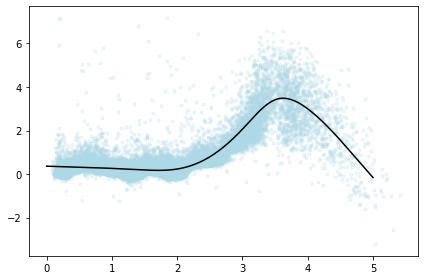

In [7]:
plt.scatter(d['z'], d['u_mag']-d['g_mag'], marker='.', color='lightblue', alpha=0.2)
plt.plot(p['z'], yhat[:, 0], '-', color='k')
plt.tight_layout()
plt.show()

The previous plot shows us a non-linear relationship between redshift and $u-g$ magnitudes. The model appears to agree with the observed data points. The appeal of the generalized additive models is that we can flexibly model quite generally. We see this here, as we did not need to manually specify where we thought the nonlinearity occurs. 

A problem with the previous plot is that it doesn't communicate uncertainty in our estimated function. While we could plot the confidence intervals from `yhat`, these would not be appropriate for inference, as they only claim to cover points and not the *function*. Instead, we will compute the confidence bands and plot those. 

In [8]:
y_vals = yhat[:, 0]                # Predicted values from model
var = estr.variance                # Variance for predictions
cov_p = Xa_pred @ var @ Xa_pred.T  # Covariance matrix for predictions

# Computing confidence bands
cb = compute_confidence_bands(y_vals, covariance=cov_p, method='supt', seed=10177)

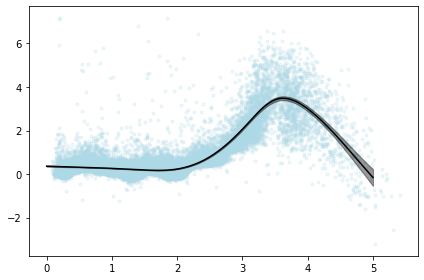

In [9]:
plt.scatter(d['z'], d['u_mag']-d['g_mag'], marker='.', color='lightblue', alpha=0.2)
plt.fill_between(p['z'], cb[:, 0], cb[:, 1], color='k', alpha=0.4)
plt.plot(p['z'], yhat[:, 0], '-', color='k')
plt.tight_layout()
plt.show()

Despite the flexibility of the model, we see our model is quite certain. However, we do see a widening at the higher values of the redshift distribution. Note that these confidence regions only account for random error. They ignore all systematic errors (e.g., measurement error).

## Colorshift $g-r$

Next, we consider the $g-r$ shift.

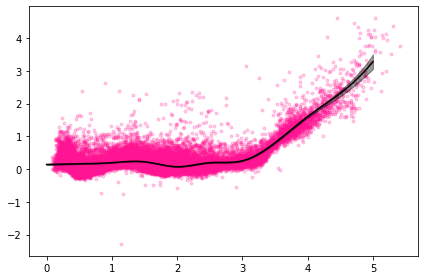

In [10]:
bshift = d['g_mag']-d['r_mag']

# Estimation
def psi(theta):
    return ee_additive_regression(theta=theta, 
                                  X=d[['intercept', 'z']], y=bshift, 
                                  specifications=specs, model='linear')

init_vals = [0.]*12
estr = MEstimator(psi, init=init_vals)
estr.estimate()

# Prediction
p = pd.DataFrame()                  # Creating empty dataframe
p['z'] = np.linspace(0, 5, 200)     # Block of evenly spaced redshift values
p['intercept'] = 1                  # Setting intercept
Xa_pred = additive_design_matrix(X=np.asarray(p[['intercept', 'z']]), specifications=specs)
yhat = regression_predictions(Xa_pred, theta=estr.theta, covariance=estr.variance)

# Confidence bands
y_vals = yhat[:, 0]                # Predicted values from model
var = estr.variance                # Variance for predictions
cov_p = Xa_pred @ var @ Xa_pred.T  # Covariance matrix for predictions
cb = compute_confidence_bands(y_vals, covariance=cov_p, method='supt', seed=10177)

# Plotting
plt.scatter(d['z'], bshift, marker='.', color='deeppink', alpha=0.2)
plt.fill_between(p['z'], cb[:, 0], cb[:, 1], color='k', alpha=0.4)
plt.plot(p['z'], yhat[:, 0], '-', color='k')
plt.tight_layout()
plt.show()

Here, we see more of a hinge point around `z=3`. Note that we made no change to our generalized additive model specification, again highlighting their general flexibility in applications

## Colorshift $g-i$

Finally, we consider the $g-i$ bandshift.

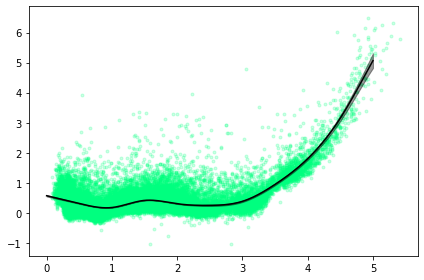

In [11]:
bshift = d['g_mag']-d['i_mag']

# Estimation
def psi(theta):
    return ee_additive_regression(theta=theta, 
                                  X=d[['intercept', 'z']], y=bshift, 
                                  specifications=specs, model='linear')

init_vals = [0.]*12
estr = MEstimator(psi, init=init_vals)
estr.estimate()

# Prediction
p = pd.DataFrame()                  # Creating empty dataframe
p['z'] = np.linspace(0, 5, 200)     # Block of evenly spaced redshift values
p['intercept'] = 1                  # Setting intercept
Xa_pred = additive_design_matrix(X=np.asarray(p[['intercept', 'z']]), specifications=specs)
yhat = regression_predictions(Xa_pred, theta=estr.theta, covariance=estr.variance)

# Confidence bands
y_vals = yhat[:, 0]                # Predicted values from model
var = estr.variance                # Variance for predictions
cov_p = Xa_pred @ var @ Xa_pred.T  # Covariance matrix for predictions
cb = compute_confidence_bands(y_vals, covariance=cov_p, method='supt', seed=10177)

# Plotting
plt.scatter(d['z'], bshift, marker='.', color='springgreen', alpha=0.2)
plt.fill_between(p['z'], cb[:, 0], cb[:, 1], color='k', alpha=0.4)
plt.plot(p['z'], yhat[:, 0], '-', color='k')
plt.tight_layout()
plt.show()

These results are similar to $g-r$, but the hinge at `z=3` is slightly less dramatic. This completes the initial exploration of the quasar data and highlights the utility of flexible regression models.

## References

Weinstein MA, et al. (2004). "An Empirical Algorithm for Broadband Photometric Redshifts of Quasars from the Sloan Digital Sky Survey". *The Astrophysical Journal Supplement Series*, 155(2), 243.